In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GaussianNoise, GlobalMaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for train and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directory in batches
Xtrain= train_datagen.flow_from_directory(
    directory='/Users/sukanya/Downloads/dataset_fracture/train',
    target_size=(256, 256),
    batch_size=100,
    class_mode='binary'
)

Xtest = test_datagen.flow_from_directory(
    directory='/Users/sukanya/Downloads/dataset_fracture/val',
    target_size=(256, 256),
    batch_size=100,
    class_mode='binary'
)

# Optionally, if you want to convert class labels to integers
class_indices = Xtrain.class_indices
train_dataset = (Xtrain, class_indices)
test_dataset = (Xtest, class_indices)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [3]:
import tensorflow as tf

# Define a function to normalize images
def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

# Convert DirectoryIterator objects to tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_generator(
    lambda: Xtrain,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: Xtest,
    output_signature=(
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

# Apply normalization using the map function
x_train = train_dataset.map(process)
x_test = test_dataset.map(process)

In [4]:
input_shape = (256, 256, 3)

In [5]:
# Creating the base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
base_model.trainable = False

94765736/94765736 [==============================] - 8s 0us/step


In [6]:
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1)                 131073    
                                                                 
Total params: 23718785 (90.48 MB)
Trainable params: 131073 (512.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [8]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
batch_size = min(100, len(Xtrain))
history = model.fit(Xtrain, epochs=10, batch_size=batch_size, validation_data=Xtest)

Epoch 1/10
89/89 [==============================] - 212s 2s/step - loss: 1.0764 - accuracy: 0.5937 - val_loss: 0.6295 - val_accuracy: 0.6633
Epoch 2/10
89/89 [==============================] - 210s 2s/step - loss: 0.6403 - accuracy: 0.6420 - val_loss: 0.6249 - val_accuracy: 0.6817
Epoch 3/10
89/89 [==============================] - 211s 2s/step - loss: 0.5936 - accuracy: 0.6764 - val_loss: 0.6355 - val_accuracy: 0.5533
Epoch 4/10
89/89 [==============================] - 212s 2s/step - loss: 0.5437 - accuracy: 0.7176 - val_loss: 0.6211 - val_accuracy: 0.5950
Epoch 5/10
89/89 [==============================] - 214s 2s/step - loss: 0.4876 - accuracy: 0.7637 - val_loss: 0.5831 - val_accuracy: 0.6933
Epoch 6/10
89/89 [==============================] - 214s 2s/step - loss: 0.5251 - accuracy: 0.7245 - val_loss: 0.6224 - val_accuracy: 0.6033
Epoch 7/10
89/89 [==============================] - 214s 2s/step - loss: 0.4490 - accuracy: 0.7838 - val_loss: 0.6790 - val_accuracy: 0.6267
Epoch 8/10
89

In [20]:
y_test = Xtest.classes

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have model predictions and true labels
predictions = model.predict(Xtest)
predicted_labels = (predictions < 0.5).astype(int)
true_labels = y_test

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

6/6 [==============================] - 15s 2s/step
Accuracy: 0.49333333333333335
Precision: 0.36324786324786323
Recall: 0.3541666666666667
F1-score: 0.35864978902953587


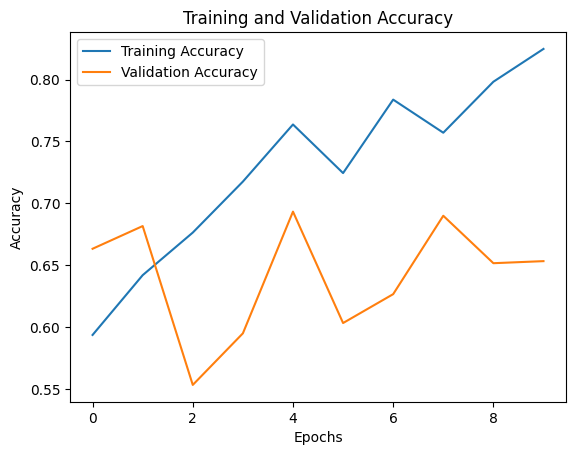

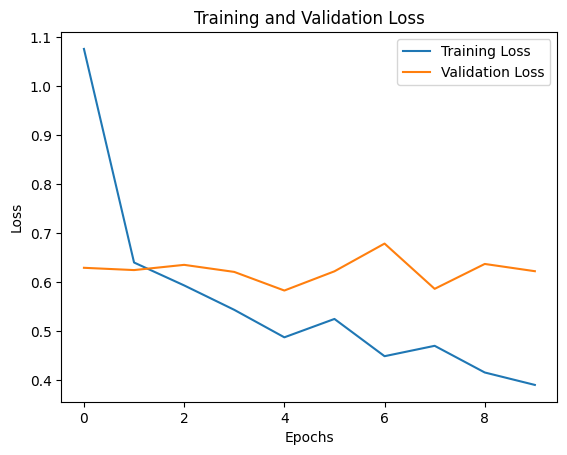

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 14s 2s/step


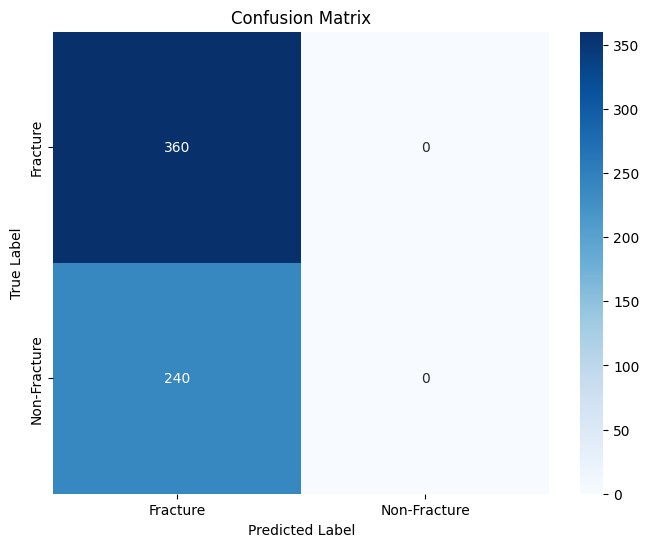

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get model predictions for the test dataset
y_pred = model.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fracture', 'Non-Fracture'], 
            yticklabels=['Fracture', 'Non-Fracture'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()